# XGBoost with Optuna Hyperparameter Tuning

### Score: 0.42311

The target variable is: 

amount_new_house_transactions: The total monetary value of new house transactions in 10,000 yuan.

We are using some of the features found in the different csv's to predict the final amount
The method used is XGBoost with cross validation

# 1. SETUP - Dependencies, dataloading

## 1.1 Dependencies and plotting style

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import sklearn
import xgboost as xgb
import optuna

from dateutil.relativedelta import relativedelta
from xgboost.callback import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from datetime import datetime

In [2]:
# Set global plot styles
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 1.2 Loads all necessary data without any processing

We first define the datapath

In [3]:
# Define the data path
DATA_PATH = Path("/Users/nikola/Python/KaggleCompetition/data")

We load the complemetary datasets which will include many of the features

In [4]:
#Submission template
submission_template = pd.read_csv("/Users/nikola/Python/KaggleCompetition/data/sample_submission.csv")

# Transaction Data (Monthly)
new_house = pd.read_csv(DATA_PATH / "train" / "new_house_transactions.csv")
pre_owned = pd.read_csv(DATA_PATH / "train" / "pre_owned_house_transactions.csv")
land = pd.read_csv(DATA_PATH / "train" / "land_transactions.csv")

# Nearby Sectors Transaction Data
new_house_nearby = pd.read_csv(DATA_PATH / "train" / "new_house_transactions_nearby_sectors.csv")
pre_owned_nearby = pd.read_csv(DATA_PATH / "train" / "pre_owned_house_transactions_nearby_sectors.csv")
land_nearby = pd.read_csv(DATA_PATH / "train" / "land_transactions_nearby_sectors.csv")

# Sector Features (Static)
sector_poi = pd.read_csv(DATA_PATH / "train" / "sector_POI.csv")

# Market Indicators (Time-series)
search_index = pd.read_csv(DATA_PATH / "train" / "city_search_index.csv")
city_indexes = pd.read_csv(DATA_PATH / "train" / "city_indexes.csv")

# Convert month columns to datetime for datasets that have it
datasets_with_month = [new_house, pre_owned, land, new_house_nearby, pre_owned_nearby, land_nearby, search_index]

for df in datasets_with_month:
    if 'month' in df.columns:
        df['month'] = pd.to_datetime(df['month'])

# Store in dictionary for easy access
datasets = {
    'new_house': new_house,
    'pre_owned': pre_owned,
    'land': land,
    'new_house_nearby': new_house_nearby,
    'pre_owned_nearby': pre_owned_nearby,
    'land_nearby': land_nearby,
    'sector_poi': sector_poi,
    'search_index': search_index,
    'city_indexes': city_indexes
}

/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/2518964697.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/2518964697.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/2518964697.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/25

In [5]:
new_house.tail()

,month,sector,num_new_house_transactions,area_new_house_transactions,price_new_house_transactions,amount_new_house_transactions,area_per_unit_new_house_transactions,total_price_per_unit_new_house_transactions,num_new_house_available_for_sale,area_new_house_available_for_sale,period_new_house_sell_through
5428,2024-07-01,sector 91,70,7921,40967,32450.06,113,463.57,2133.0,341192.0,51.82
5429,2024-07-01,sector 92,211,22084,13949,30804.74,105,145.99,5908.0,636696.0,34.76
5430,2024-07-01,sector 93,62,8136,27452,22335.30,131,360.25,1323.0,150862.0,27.74
5431,2024-07-01,sector 94,44,5078,26367,13389.41,115,304.30,2027.0,215821.0,38.62
5432,2024-07-01,sector 96,1,140,40079,561.19,140,561.19,1.0,195.0,1.39


# 2. DATA & FEATURE ENGINEERING - Merging, cleaning, handling missing values


In [6]:
# ------------------------------------------
# 3.1 Create Master Dataset - Selected Features Only
# ------------------------------------------

# Start with new_house as base (contains target)
df = new_house.copy()

# Define target variable
target_col = 'amount_new_house_transactions'

# Define exactly which columns to merge from each dataset
columns_to_merge = {
    'pre_owned': [
        'month', 'sector',
        'area_pre_owned_house_transactions',
        'amount_pre_owned_house_transactions',
        'num_pre_owned_house_transactions',
        'price_pre_owned_house_transactions'
    ],
    'land': [
        'month', 'sector',
        'num_land_transactions',
        'planned_building_area',
        'transaction_amount'
    ],
    'new_house_nearby': [
        'month', 'sector',
        'num_new_house_transactions_nearby_sectors',
        'area_new_house_transactions_nearby_sectors',
        'amount_new_house_transactions_nearby_sectors',
        'price_new_house_transactions_nearby_sectors'
    ],
    'pre_owned_nearby': [
        'month', 'sector',
        'num_pre_owned_house_transactions_nearby_sectors',
        'amount_pre_owned_house_transactions_nearby_sectors',
        'price_pre_owned_house_transactions_nearby_sectors'
    ],
    'land_nearby': [
        'month', 'sector',
        'num_land_transactions_nearby_sectors',
        'planned_building_area_nearby_sectors',
        'transaction_amount_nearby_sectors'
    ]
}

# Merge each dataset with specific columns
for data, name in [(pre_owned, 'pre_owned'), (land, 'land'), 
                   (new_house_nearby, 'new_house_nearby'),
                   (pre_owned_nearby, 'pre_owned_nearby'),
                   (land_nearby, 'land_nearby')]:
    
    # Columns to use (all exist, no if-check needed)
    cols_to_use = columns_to_merge[name]
    
    # Merge
    df = df.merge(data[cols_to_use], on=['month', 'sector'], how='left')
    print(f"Merged {name}: added {len(cols_to_use)-2} features, shape: {df.shape}")

# ------------------------------------------
# Split combined ID into month and sector (if needed)
# ------------------------------------------
if 'month_sector' in df.columns:
    df[['month', 'sector']] = df['month_sector'].str.split('_', expand=True)
    df['month'] = pd.to_datetime(df['month'], format='%Y-%m')
    df['sector'] = df['sector'].astype('category').cat.codes

print(f"\nFinal dataset shape: {df.shape}")
print(f"Total features (excluding target): {df.shape[1] - 1}")

Merged pre_owned: added 4 features, shape: (5433, 15)
Merged land: added 3 features, shape: (5433, 18)
Merged new_house_nearby: added 4 features, shape: (5433, 22)
Merged pre_owned_nearby: added 3 features, shape: (5433, 25)
Merged land_nearby: added 3 features, shape: (5433, 28)

Final dataset shape: (5433, 28)
Total features (excluding target): 27


In [7]:
# ------------------------------------------
# 3.2 Create Time Features
# ------------------------------------------

df['date'] = pd.to_datetime(df['month'])
df['month_num'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year
df['days_in_month'] = df['date'].dt.days_in_month

# Cyclical encoding for month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

In [8]:
# ------------------------------------------
# 3.3 Create Lag Features
# ------------------------------------------

# Sort by sector and date for proper lag calculation
df = df.sort_values(['sector', 'date'])

# Target lags
target_col = 'amount_new_house_transactions'
lag_periods = [1, 2, 3, 6, 12]

for lag in lag_periods:
    df[f'{target_col}_lag_{lag}'] = df.groupby('sector')[target_col].shift(lag)

# Rolling statistics for target
rolling_windows = [3, 6, 12]
for window in rolling_windows:
    df[f'{target_col}_rolling_mean_{window}'] = (
        df.groupby('sector')[target_col]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
    )
    df[f'{target_col}_rolling_std_{window}'] = (
        df.groupby('sector')[target_col]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).std())
    )

# Price momentum features
if 'price_new_house_transactions' in df.columns:
    for lag in [1, 3, 6]:
        df[f'price_change_{lag}m'] = (
            df.groupby('sector')['price_new_house_transactions'].pct_change(lag)
        )

In [9]:
# ------------------------------------------
# 3.4 Create Ratio Features
# ------------------------------------------

# Supply/demand indicators
if all(col in df.columns for col in ['num_new_house_available_for_sale', 'num_new_house_transactions']):
    df['supply_demand_ratio'] = (
        df['num_new_house_available_for_sale'] / 
        (df['num_new_house_transactions'] + 1)  # +1 to avoid division by zero
    )

# Price ratios
if all(col in df.columns for col in ['price_new_house_transactions', 'price_pre_owned_house_transactions']):
    df['new_vs_preowned_price_ratio'] = (
        df['price_new_house_transactions'] / 
        (df['price_pre_owned_house_transactions'] + 1)
    )

# Nearby market influence
if all(col in df.columns for col in ['amount_new_house_transactions', 'amount_new_house_transactions_nearby_sectors']):
    df['local_vs_nearby_ratio'] = (
        df['amount_new_house_transactions'] / 
        (df['amount_new_house_transactions_nearby_sectors'] + 1)
    )

In [10]:
# ------------------------------------------
# 3.5 Compute EWGM per sector
# ------------------------------------------

def ewgm_per_sector(a_tr, n_lags=6, alpha=0.5):
    """Compute EWGM for each sector and return a Series mapping sector -> EWGM."""
    ewgm_map = {}
    for sector, group in a_tr.groupby('sector'):
        recent = group.sort_values('month')[target_col].tail(n_lags).values
        if len(recent) < n_lags or (recent <= 0).all():
            ewgm_map[sector] = 0.0
            continue
        weights = np.array([alpha**(n_lags - 1 - i) for i in range(n_lags)])
        weights /= weights.sum()
        mask = recent > 0
        if not mask.any():
            ewgm_map[sector] = 0.0
            continue
        log_vals = np.log(recent[mask] + 1e-12)
        pos_w = weights[mask] / weights[mask].sum()
        ewgm_map[sector] = float(np.exp(np.sum(pos_w * log_vals)))
    return pd.Series(ewgm_map)

# Compute EWGM for all sectors
df['ewgm_pred'] = df['sector'].map(ewgm_per_sector(df))

print("\nAdded EWGM feature 'ewgm_pred'")
print(f"\nFinal dataset shape: {df.shape}")
print(f"Total features (excluding target): {df.shape[1] - 1}")


Added EWGM feature 'ewgm_pred'

Final dataset shape: (5433, 53)
Total features (excluding target): 52


In [11]:
# ------------------------------------------
# 3.6 Handle Missing Values
# ------------------------------------------

# For low missing (<1%), use median
low_missing_cols = [
    'num_new_house_available_for_sale',
    'area_new_house_available_for_sale',
    'period_new_house_sell_through',
    'price_pre_owned_house_transactions'
]

for col in low_missing_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/2620936971.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/2620936971.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [12]:
# ------------------------------------------
# 3.7 Remove Data Leakage Columns
# ------------------------------------------

# These might directly calculate the target
potential_leakage = [
    'area_new_house_transactions',  # amount = area * price
    'total_price_per_unit_new_house_transactions'  # directly related to amount
]

print(f"\nRemoving potential leakage columns: {[col for col in potential_leakage if col in df.columns]}")
df.drop(columns=[col for col in potential_leakage if col in df.columns], inplace=True)



Removing potential leakage columns: ['area_new_house_transactions', 'total_price_per_unit_new_house_transactions']


In [13]:
# ------------------------------------------
# 3.8 Final Dataset Info
# ------------------------------------------

print("\n" + "="*40)
print("PREPROCESSING COMPLETE")
print("="*40)
print(f"Final dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print(f"Target variable: {target_col}")
print(f"Number of features: {len(df.columns) - 1}")  # -1 for target

# Save processed data
output_path = Path("/Users/nikola/Python/KaggleCompetition/data")
df.to_csv(output_path / "processed_data.csv", index=False)
print(f"\nProcessed data saved to: {output_path / 'processed_data.csv'}")

# Keep a copy for modeling
df_processed = df.copy()

df.info()


PREPROCESSING COMPLETE
Final dataset shape: (5433, 51)
Memory usage: 2.07 MB
Target variable: amount_new_house_transactions
Number of features: 50

Processed data saved to: /Users/nikola/Python/KaggleCompetition/data/processed_data.csv
<class 'pandas.core.frame.DataFrame'>
Index: 5433 entries, 0 to 5432
Data columns (total 51 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   month                                               5433 non-null   datetime64[ns]
 1   sector                                              5433 non-null   object        
 2   num_new_house_transactions                          5433 non-null   int64         
 3   price_new_house_transactions                        5433 non-null   int64         
 4   amount_new_house_transactions                       5433 non-null   float64       
 5   area_per_unit_new_house_transactions    

# 3. PANEL DATA - CROSS VALIDATION

In [14]:
# ==========================================
# 4.1 CROSS-VALIDATION SETUP
# ==========================================

print("="*60)
print("CROSS-VALIDATION SETUP")
print("="*60)

# Sort data by time (critical for time series)
df = df.sort_values(['month', 'sector']).reset_index(drop=True)

# Check data span
print(f"Data span: {df['month'].min()} to {df['month'].max()}")
print(f"Total months: {df['month'].nunique()}")
print(f"Total sectors: {df['sector'].nunique()}")
print(f"Total rows: {len(df)}")

# Define features and target
target_col = 'amount_new_house_transactions'
non_features = ['month', 'date', target_col]
feature_cols = [col for col in df.columns if col not in non_features]

print(f"\nFeatures for model: {len(feature_cols)}")

# Prepare X and y
X = df[feature_cols]
y = df[target_col]

# Remove rows where target is NaN
mask = ~y.isna()
X = X[mask]
y = y[mask]
print(f"After removing NaN targets: {len(X)} rows")

# Simple TimeSeriesSplit
# For monthly data: test_size = number of months to use as test
# Let's use 6 months as test set for each fold
tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=6 * df['sector'].nunique(),  # 6 months * number of sectors
    gap=0  # No gap needed for monthly data
)

# Display the splits
print("\nCross-validation splits:")
print("-" * 40)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_months = df.iloc[train_idx]['month'].unique()
    test_months = df.iloc[test_idx]['month'].unique()
    print(f"Fold {i+1}:")
    print(f"  Train: {len(train_idx):,} rows ({len(train_months)} months)")
    print(f"  Test:  {len(test_idx):,} rows ({len(test_months)} months)")
    print(f"  Test period: {test_months.min()} to {test_months.max()}")

CROSS-VALIDATION SETUP
Data span: 2019-01-01 00:00:00 to 2024-07-01 00:00:00
Total months: 67
Total sectors: 95
Total rows: 5433

Features for model: 48
After removing NaN targets: 5433 rows

Cross-validation splits:
----------------------------------------
Fold 1:
  Train: 2,583 rows (33 months)
  Test:  570 rows (8 months)
  Test period: 2021-09-01 00:00:00 to 2022-04-01 00:00:00
Fold 2:
  Train: 3,153 rows (40 months)
  Test:  570 rows (8 months)
  Test period: 2022-04-01 00:00:00 to 2022-11-01 00:00:00
Fold 3:
  Train: 3,723 rows (47 months)
  Test:  570 rows (8 months)
  Test period: 2022-11-01 00:00:00 to 2023-06-01 00:00:00
Fold 4:
  Train: 4,293 rows (54 months)
  Test:  570 rows (8 months)
  Test period: 2023-06-01 00:00:00 to 2024-01-01 00:00:00
Fold 5:
  Train: 4,863 rows (61 months)
  Test:  570 rows (7 months)
  Test period: 2024-01-01 00:00:00 to 2024-07-01 00:00:00
Data span: 2019-01-01 00:00:00 to 2024-07-01 00:00:00
Total months: 67
Total sectors: 95
Total rows: 5433



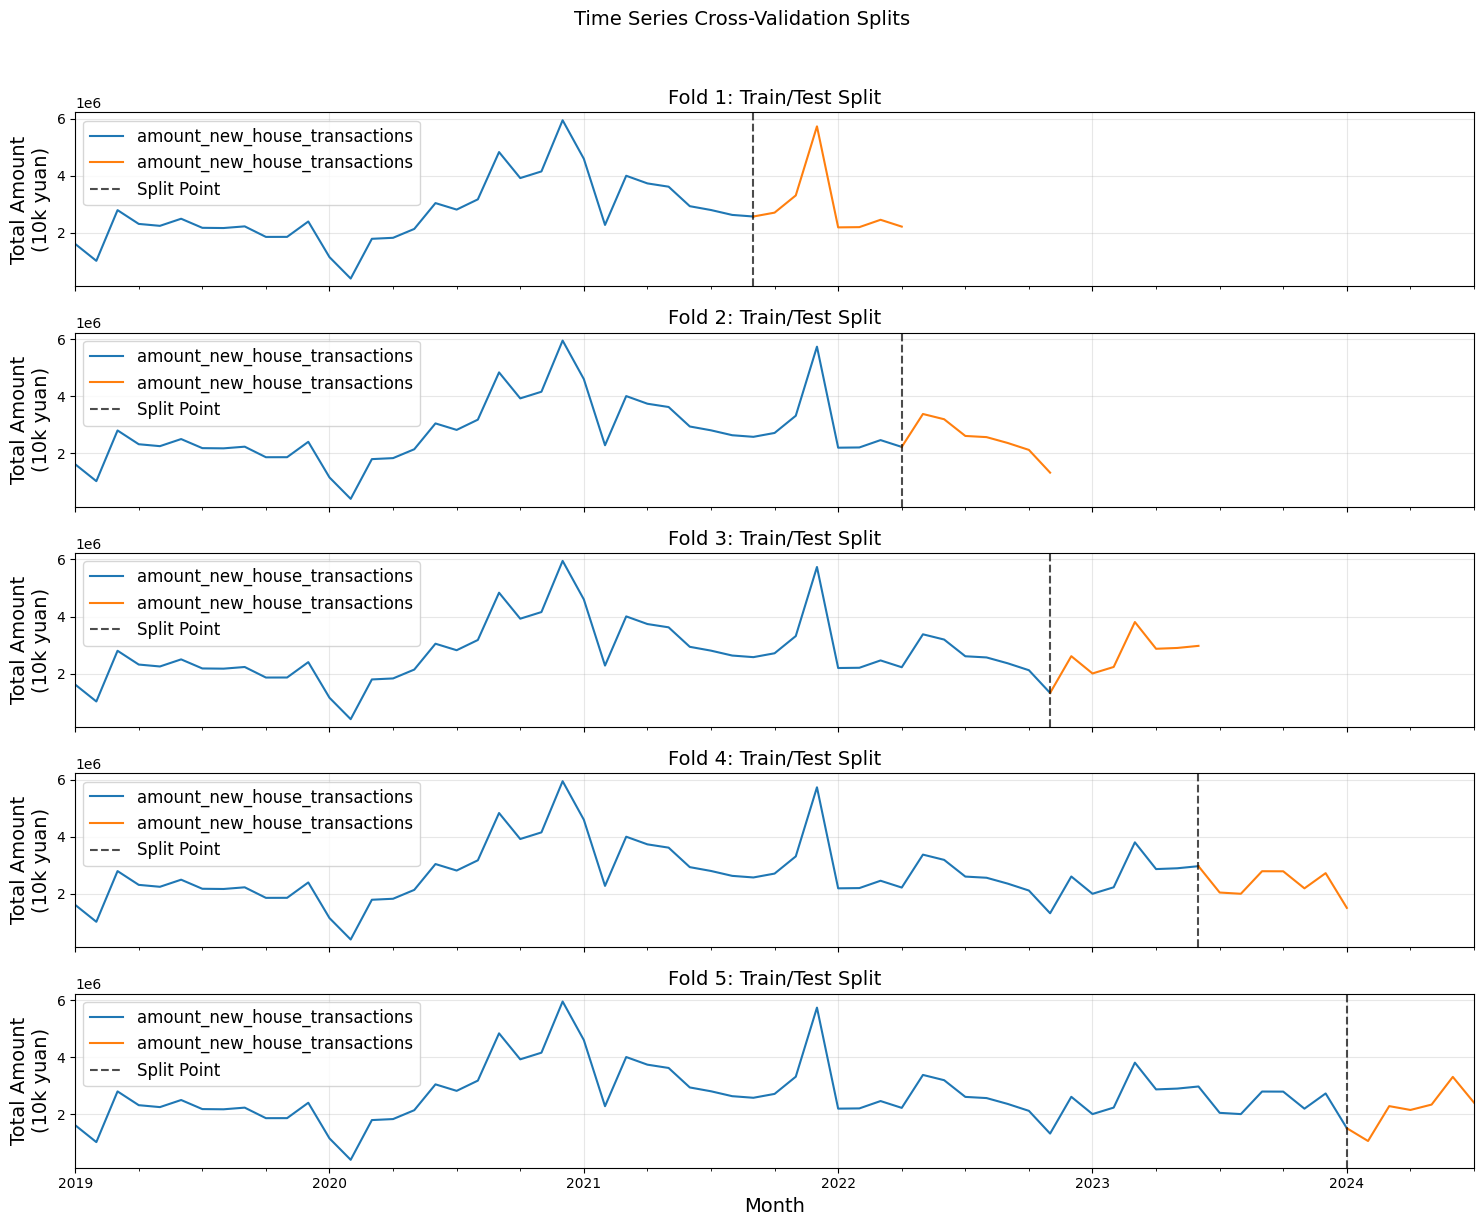


SPLIT STATISTICS

Fold 1:
  Train mean: 33,885
  Test mean:  38,492
  Difference: +13.6%

Fold 2:
  Train mean: 34,718
  Test mean:  31,281
  Difference: -9.9%

Fold 3:
  Train mean: 34,192
  Test mean:  31,237
  Difference: -8.6%

Fold 4:
  Train mean: 33,799
  Test mean:  29,970
  Difference: -11.3%

Fold 5:
  Train mean: 33,350
  Test mean:  26,080
  Difference: -21.8%


In [15]:
# ==========================================
# 4.2 VISUALIZE CROSS-VALIDATION SPLITS
# ==========================================

# Since we have multiple sectors, let's aggregate by month for visualization
monthly_target = df.groupby('month')[target_col].sum().reset_index()
monthly_target = monthly_target.set_index('month').sort_index()

# Create figure
fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Time Series Cross-Validation Splits', fontsize=14, y=1.02)

# Plot each fold
fold = 0
for train_idx, test_idx in tscv.split(X):
    # Get train/test months
    train_months = df.iloc[train_idx]['month'].unique()
    test_months = df.iloc[test_idx]['month'].unique()
    
    # Filter monthly aggregated data
    train_data = monthly_target[monthly_target.index.isin(train_months)]
    test_data = monthly_target[monthly_target.index.isin(test_months)]
    
    # Plot
    train_data.plot(ax=axes[fold], 
                    label='Training Set',
                    color='#1f77b4',
                    title=f'Fold {fold+1}: Train/Test Split')
    test_data.plot(ax=axes[fold], 
                   label='Test Set',
                   color='#ff7f0e')
    
    # Add vertical line at split point
    axes[fold].axvline(test_data.index.min(), 
                       color='black', 
                       ls='--', 
                       alpha=0.7,
                       label='Split Point')
    
    # Format
    axes[fold].set_ylabel('Total Amount\n(10k yuan)')
    axes[fold].legend(loc='upper left')
    axes[fold].grid(True, alpha=0.3)
    
    fold += 1

axes[-1].set_xlabel('Month')
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*40)
print("SPLIT STATISTICS")
print("="*40)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_y = y.iloc[train_idx]
    test_y = y.iloc[test_idx]
    print(f"\nFold {i+1}:")
    print(f"  Train mean: {train_y.mean():,.0f}")
    print(f"  Test mean:  {test_y.mean():,.0f}")
    print(f"  Difference: {(test_y.mean() - train_y.mean())/train_y.mean()*100:+.1f}%")

# 4. MODELING - XGBoost and Visualisations

In [16]:
    # ==========================================
    # 5.1 CROSS-VALIDATION WITH XGBOOST
    # ==========================================
    
    print("="*60)
    print("CROSS-VALIDATION WITH XGBOOST")
    print("="*60)
    
    scores = []
    models = []
    preds = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"\n--- Fold {fold+1} ---")
        
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        print(f"Train: {len(X_train):,} samples")
        print(f"Test:  {len(X_test):,} samples")
        
        # XGBoost model
        reg = xgb.XGBRegressor(
            n_estimators=500,
            max_depth=5,
            learning_rate=0.01,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            early_stopping_rounds=50,
            enable_categorical=True
        )
    
        # Convert 'sector' column to categorical type
        X_train['sector'] = X_train['sector'].astype('category')
        X_test['sector'] = X_test['sector'].astype('category')
        
        # Train
        reg.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100
        )
        
        # Predict
        y_pred = reg.predict(X_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
        models.append(reg)
        preds.append(y_pred)
        
        print(f"RMSE: {rmse:,.0f}")
    
    print(f"\n--- CROSS-VALIDATION RESULTS ---")
    print(f"Average RMSE: {np.mean(scores):,.0f}")
    print(f"Std RMSE: {np.std(scores):,.0f}")
    print(f"Best fold: {np.argmin(scores)+1} (RMSE: {np.min(scores):,.0f})")

CROSS-VALIDATION WITH XGBOOST

--- Fold 1 ---
Train: 2,583 samples
Test:  570 samples
[0]	validation_0-rmse:53762.71727	validation_1-rmse:57331.72614
[100]	validation_0-rmse:23595.63713	validation_1-rmse:40214.06626
[100]	validation_0-rmse:23595.63713	validation_1-rmse:40214.06626


/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['sector'] = X_train['sector'].astype('category')
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['sector'] = X_test['sector'].astype('category')


[200]	validation_0-rmse:11470.88306	validation_1-rmse:32849.92457
[300]	validation_0-rmse:6422.09852	validation_1-rmse:29483.24927
[300]	validation_0-rmse:6422.09852	validation_1-rmse:29483.24927
[400]	validation_0-rmse:4193.71634	validation_1-rmse:27971.37818
[400]	validation_0-rmse:4193.71634	validation_1-rmse:27971.37818
[499]	validation_0-rmse:3121.57897	validation_1-rmse:27200.56499
[499]	validation_0-rmse:3121.57897	validation_1-rmse:27200.56499
RMSE: 27,201

--- Fold 2 ---
Train: 3,153 samples
Test:  570 samples
[0]	validation_0-rmse:54384.40347	validation_1-rmse:41179.95946
RMSE: 27,201

--- Fold 2 ---
Train: 3,153 samples
Test:  570 samples
[0]	validation_0-rmse:54384.40347	validation_1-rmse:41179.95946
[100]	validation_0-rmse:24192.34540	validation_1-rmse:25922.96281
[100]	validation_0-rmse:24192.34540	validation_1-rmse:25922.96281


/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['sector'] = X_train['sector'].astype('category')
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['sector'] = X_test['sector'].astype('category')


[200]	validation_0-rmse:11850.67821	validation_1-rmse:21191.23193
[300]	validation_0-rmse:6584.22494	validation_1-rmse:19477.34717
[300]	validation_0-rmse:6584.22494	validation_1-rmse:19477.34717
[400]	validation_0-rmse:4240.21649	validation_1-rmse:18797.26161
[400]	validation_0-rmse:4240.21649	validation_1-rmse:18797.26161
[499]	validation_0-rmse:3130.08926	validation_1-rmse:18505.52109
[499]	validation_0-rmse:3130.08926	validation_1-rmse:18505.52109
RMSE: 18,506

--- Fold 3 ---
Train: 3,723 samples
Test:  570 samples
[0]	validation_0-rmse:52575.19358	validation_1-rmse:44661.69025
RMSE: 18,506

--- Fold 3 ---
Train: 3,723 samples
Test:  570 samples
[0]	validation_0-rmse:52575.19358	validation_1-rmse:44661.69025
[100]	validation_0-rmse:23777.11493	validation_1-rmse:28916.69472
[100]	validation_0-rmse:23777.11493	validation_1-rmse:28916.69472


/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['sector'] = X_train['sector'].astype('category')
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['sector'] = X_test['sector'].astype('category')


[200]	validation_0-rmse:11942.74136	validation_1-rmse:23160.52661
[300]	validation_0-rmse:6826.44759	validation_1-rmse:20348.35155
[300]	validation_0-rmse:6826.44759	validation_1-rmse:20348.35155
[400]	validation_0-rmse:4545.31595	validation_1-rmse:18943.03071
[400]	validation_0-rmse:4545.31595	validation_1-rmse:18943.03071
[499]	validation_0-rmse:3435.20796	validation_1-rmse:18088.69289
[499]	validation_0-rmse:3435.20796	validation_1-rmse:18088.69289
RMSE: 18,089

--- Fold 4 ---
Train: 4,293 samples
Test:  570 samples
[0]	validation_0-rmse:51576.98336	validation_1-rmse:35748.78532
RMSE: 18,089

--- Fold 4 ---
Train: 4,293 samples
Test:  570 samples
[0]	validation_0-rmse:51576.98336	validation_1-rmse:35748.78532
[100]	validation_0-rmse:23554.40550	validation_1-rmse:19279.61544
[100]	validation_0-rmse:23554.40550	validation_1-rmse:19279.61544


/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['sector'] = X_train['sector'].astype('category')
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['sector'] = X_test['sector'].astype('category')


[200]	validation_0-rmse:11915.95863	validation_1-rmse:12833.60106
[300]	validation_0-rmse:6843.69417	validation_1-rmse:10362.69554
[300]	validation_0-rmse:6843.69417	validation_1-rmse:10362.69554
[400]	validation_0-rmse:4544.23149	validation_1-rmse:9274.35434
[400]	validation_0-rmse:4544.23149	validation_1-rmse:9274.35434
[499]	validation_0-rmse:3430.20769	validation_1-rmse:8863.31893
[499]	validation_0-rmse:3430.20769	validation_1-rmse:8863.31893
RMSE: 8,863

--- Fold 5 ---
Train: 4,863 samples
Test:  570 samples
[0]	validation_0-rmse:49979.75451	validation_1-rmse:35176.03919
RMSE: 8,863

--- Fold 5 ---
Train: 4,863 samples
Test:  570 samples
[0]	validation_0-rmse:49979.75451	validation_1-rmse:35176.03919
[100]	validation_0-rmse:22844.62855	validation_1-rmse:19068.66812
[100]	validation_0-rmse:22844.62855	validation_1-rmse:19068.66812


/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['sector'] = X_train['sector'].astype('category')
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/4165720730.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['sector'] = X_test['sector'].astype('category')


[200]	validation_0-rmse:11572.15197	validation_1-rmse:12657.79876
[300]	validation_0-rmse:6702.31072	validation_1-rmse:10318.56367
[300]	validation_0-rmse:6702.31072	validation_1-rmse:10318.56367
[400]	validation_0-rmse:4505.62267	validation_1-rmse:9401.44397
[400]	validation_0-rmse:4505.62267	validation_1-rmse:9401.44397
[499]	validation_0-rmse:3432.71171	validation_1-rmse:9032.98670
RMSE: 9,033

--- CROSS-VALIDATION RESULTS ---
Average RMSE: 16,338
Std RMSE: 6,856
Best fold: 4 (RMSE: 8,863)
[499]	validation_0-rmse:3432.71171	validation_1-rmse:9032.98670
RMSE: 9,033

--- CROSS-VALIDATION RESULTS ---
Average RMSE: 16,338
Std RMSE: 6,856
Best fold: 4 (RMSE: 8,863)


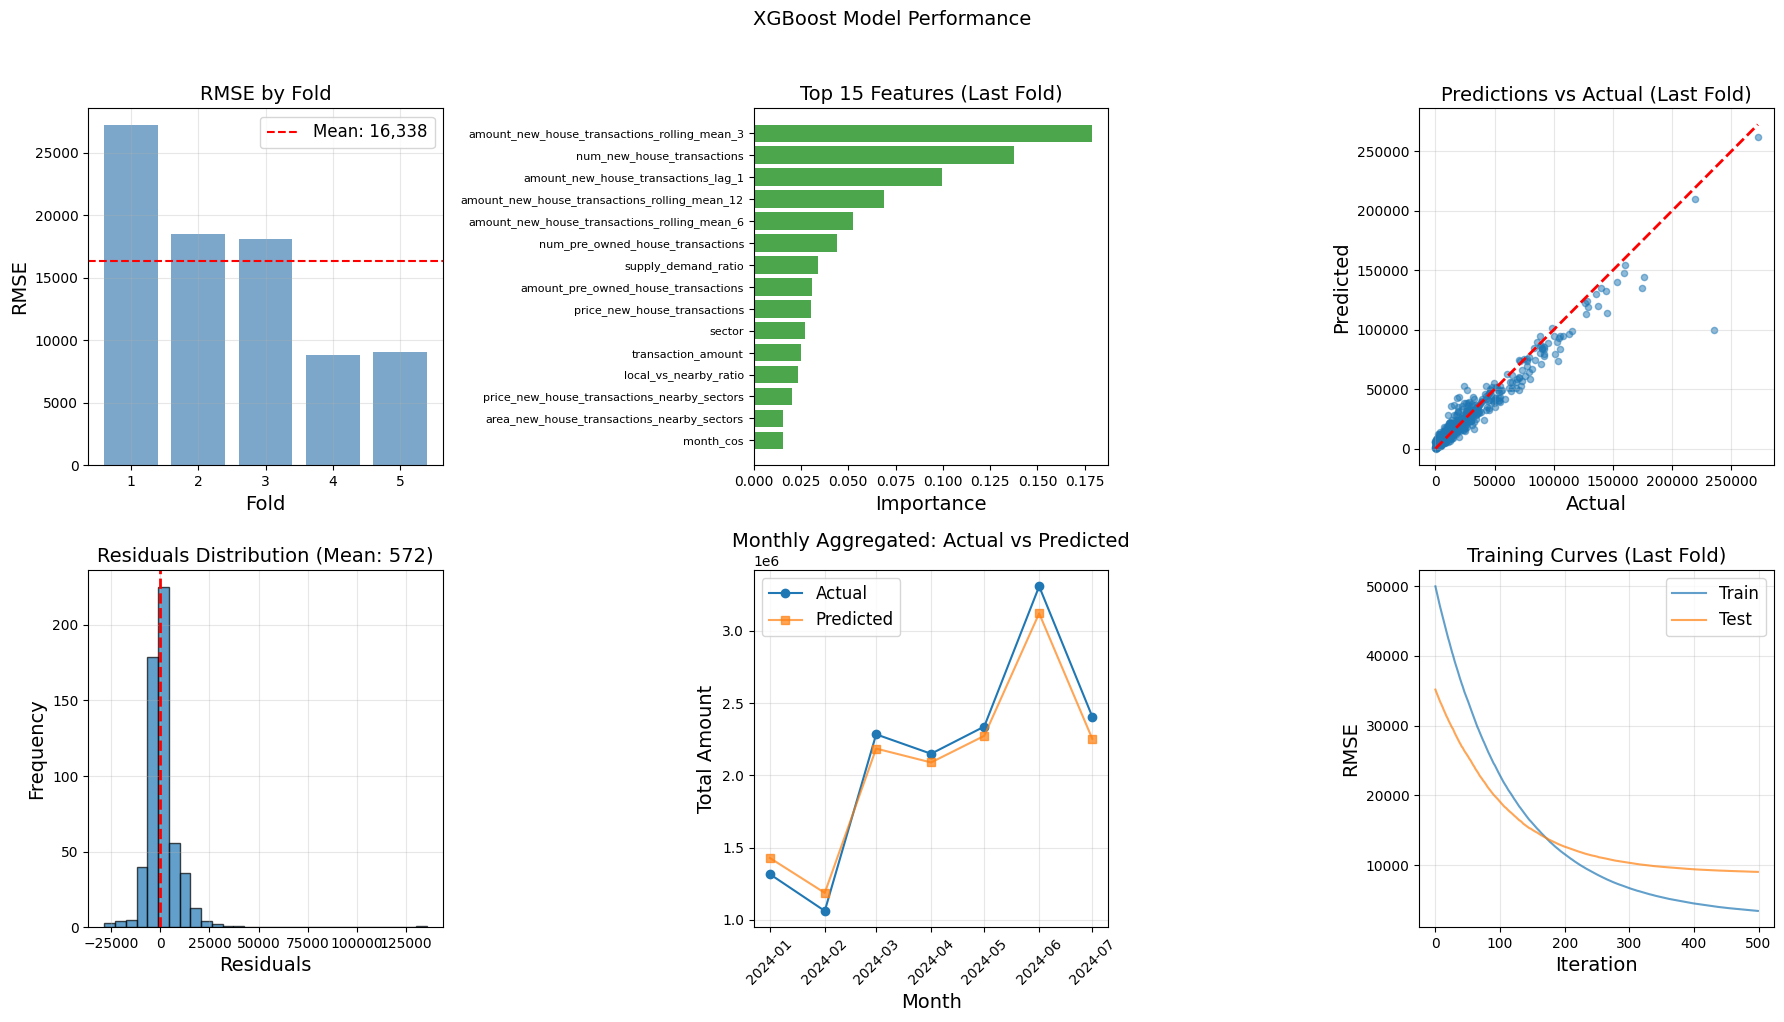


PERFORMANCE SUMMARY
Average RMSE: 16,338
Best Fold: 4 (RMSE: 8,863)
Worst Fold: 1 (RMSE: 27,201)
Standard Deviation: 6,856


In [17]:
# ==========================================
# 5.2 VISUALIZATION OF RESULTS
# ==========================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. RMSE across folds
axes[0, 0].bar(range(1, len(scores)+1), scores, color='steelblue', alpha=0.7)
axes[0, 0].axhline(np.mean(scores), color='red', linestyle='--', label=f'Mean: {np.mean(scores):,.0f}')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE by Fold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Feature importance (from last model)
last_model = models[-1]
importances = last_model.feature_importances_
indices = np.argsort(importances)[::-1][:15]  # Top 15

axes[0, 1].barh(range(15), importances[indices], color='green', alpha=0.7)
axes[0, 1].set_yticks(range(15))
axes[0, 1].set_yticklabels([feature_cols[i] for i in indices], fontsize=8)
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Top 15 Features (Last Fold)')
axes[0, 1].invert_yaxis()

# 3. Predictions vs Actual (last fold)
# Get last fold data
last_test_idx = list(tscv.split(df))[-1][1]
last_test = df.iloc[last_test_idx]
X_last = last_test[feature_cols]
y_last = last_test[target_col]
test_mask = ~y_last.isna()
y_true = y_last[test_mask]
y_pred = preds[-1]

axes[0, 2].scatter(y_true, y_pred, alpha=0.5, s=20)
axes[0, 2].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual')
axes[0, 2].set_ylabel('Predicted')
axes[0, 2].set_title('Predictions vs Actual (Last Fold)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Residuals
residuals = y_true - y_pred
axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Residuals Distribution (Mean: {np.mean(residuals):,.0f})')
axes[1, 0].grid(True, alpha=0.3)

# 5. Predictions over time (last fold)
test_with_pred = last_test[test_mask].copy()
test_with_pred['predictions'] = y_pred
monthly_actual = test_with_pred.groupby('month')[target_col].sum()
monthly_pred = test_with_pred.groupby('month')['predictions'].sum()

axes[1, 1].plot(monthly_actual.index, monthly_actual.values, label='Actual', marker='o')
axes[1, 1].plot(monthly_pred.index, monthly_pred.values, label='Predicted', marker='s', alpha=0.7)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Total Amount')
axes[1, 1].set_title('Monthly Aggregated: Actual vs Predicted')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Learning curves (last model)
results = last_model.evals_result()
axes[1, 2].plot(results['validation_0']['rmse'], label='Train', alpha=0.7)
axes[1, 2].plot(results['validation_1']['rmse'], label='Test', alpha=0.7)
axes[1, 2].set_xlabel('Iteration')
axes[1, 2].set_ylabel('RMSE')
axes[1, 2].set_title('Training Curves (Last Fold)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('XGBoost Model Performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print performance summary
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(f"Average RMSE: {np.mean(scores):,.0f}")
print(f"Best Fold: {np.argmin(scores) + 1} (RMSE: {np.min(scores):,.0f})")
print(f"Worst Fold: {np.argmax(scores) + 1} (RMSE: {np.max(scores):,.0f})")
print(f"Standard Deviation: {np.std(scores):,.0f}")

In [18]:
# ==========================================
# 5.3 OPTUNA HYPERPARAMETER TUNING
# ==========================================

print("="*60)
print("OPTUNA HYPERPARAMETER TUNING")
print("="*60)

def objective(trial):
    """Optuna objective function for hyperparameter tuning"""
    
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'enable_categorical': True
    }
    
    # Cross-validation scores
    cv_scores = []
    
    # Use only 3 folds for faster tuning
    for fold, (train_idx, test_idx) in enumerate(list(tscv.split(X))[:3]):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Convert 'sector' to categorical in the original X DataFrame if it's not already
        if X_train['sector'].dtype == 'object':
            X_train = X_train.copy()
            X_test = X_test.copy()
            X_train['sector'] = X_train['sector'].astype('category')
            X_test['sector'] = X_test['sector'].astype('category')
        
        # Create and train model
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, verbose=False)
        
        # Predict and calculate RMSE
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        cv_scores.append(rmse)
    
    # Return average RMSE
    return np.mean(cv_scores)

# Create and run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\nBest trial:")
print(f"Value (RMSE): {study.best_value:,.0f}")
print(f"Params: {study.best_params}")

[I 2025-10-02 14:33:39,736] A new study created in memory with name: no-name-434826a7-fb94-43b9-9896-19de259eacf7


OPTUNA HYPERPARAMETER TUNING


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-02 14:33:41,616] Trial 0 finished with value: 18412.116477502634 and parameters: {'n_estimators': 828, 'max_depth': 4, 'learning_rate': 0.29987006281492423, 'subsample': 0.6734252935018644, 'colsample_bytree': 0.6321414010421852, 'min_child_weight': 6, 'gamma': 3.577433962941175}. Best is trial 0 with value: 18412.116477502634.
[I 2025-10-02 14:33:42,791] Trial 1 finished with value: 16639.089486924575 and parameters: {'n_estimators': 573, 'max_depth': 4, 'learning_rate': 0.07360546207097121, 'subsample': 0.7578410204422626, 'colsample_bytree': 0.641469172136631, 'min_child_weight': 5, 'gamma': 4.119363587909418}. Best is trial 1 with value: 16639.089486924575.
[I 2025-10-02 14:33:42,791] Trial 1 finished with value: 16639.089486924575 and parameters: {'n_estimators': 573, 'max_depth': 4, 'learning_rate': 0.07360546207097121, 'subsample': 0.7578410204422626, 'colsample_bytree': 0.641469172136631, 'min_child_weight': 5, 'gamma': 4.119363587909418}. Best is trial 1 with value:

In [19]:
study.best_params

{'n_estimators': 502,
 'max_depth': 8,
 'learning_rate': 0.03561038310382061,
 'subsample': 0.8428270092983864,
 'colsample_bytree': 0.997361971615462,
 'min_child_weight': 7,
 'gamma': 1.2971407818041774}

# 6. PREDICTING THE FUTURE
Retraining on all data

To Predict the future we need an emtpy dataframe for future date ranges.

Run those dates through our feature creation code + lag creation

In [20]:
final_model = xgb.XGBRegressor(
    n_estimators=964,
    max_depth=5,
    learning_rate=0.050196170620092684,
    subsample=0.8753244411598609,
    colsample_bytree=0.9693334022937669,
    min_child_weight=1,
    gamma=2.3212736149789897,
    enable_categorical=True
)

# 7. SAVE TO THE SAMPLE SUBMISSION

In [22]:
# ------------------------------------------
# 7.1 Create Final Submission
# ------------------------------------------

# First, we need to create future data and generate predictions
# Parse submission template to get future month-sector combinations
future_data = []
for row_id in submission_template['id']:
    month_str, sector_str = row_id.split('_')
    month = pd.to_datetime(month_str, format='%Y %b')
    sector = sector_str
    future_data.append({'month': month, 'sector': sector, 'id': row_id})

future_df = pd.DataFrame(future_data)

# Create a complete dataset with historical + future rows
# We'll use the last known values for most features and let the model extrapolate
combined_df = pd.concat([df, future_df.assign(**{col: np.nan for col in df.columns if col not in ['month', 'sector']})], 
                       ignore_index=True)

# Sort by sector and month for proper lag calculation
combined_df = combined_df.sort_values(['sector', 'month']).reset_index(drop=True)

# Recreate lag features for the combined dataset (including future periods)
combined_df = combined_df.sort_values(['sector', 'month'])

# Target lags - these will be available for future predictions
lag_periods = [1, 2, 3, 6, 12]
for lag in lag_periods:
    combined_df[f'{target_col}_lag_{lag}'] = combined_df.groupby('sector')[target_col].shift(lag)

# Recreate other engineered features for future data
# Time features
combined_df['date'] = combined_df['month']
combined_df['month_num'] = combined_df['date'].dt.month
combined_df['quarter'] = combined_df['date'].dt.quarter
combined_df['year'] = combined_df['date'].dt.year
combined_df['days_in_month'] = combined_df['date'].dt.days_in_month
combined_df['month_sin'] = np.sin(2 * np.pi * combined_df['month_num'] / 12)
combined_df['month_cos'] = np.cos(2 * np.pi * combined_df['month_num'] / 12)

# For simplicity, fill missing features in future data with forward fill or median
future_mask = combined_df[target_col].isna()
for col in feature_cols:
    if col in combined_df.columns and combined_df[col].isna().any():
        # Forward fill within each sector, then use median
        combined_df[col] = combined_df.groupby('sector')[col].fillna(method='ffill')
        combined_df[col] = combined_df[col].fillna(combined_df[col].median())

# Train final model on all historical data
X_all = df[feature_cols]
y_all = df[target_col]

# Remove rows where target is NaN
mask = ~y_all.isna()
X_all = X_all[mask]
y_all = y_all[mask]

# Convert 'sector' to categorical
X_all['sector'] = X_all['sector'].astype('category')

# Train final model with optimized parameters
final_model.fit(X_all, y_all)

# Prepare future data for prediction
X_future = combined_df[future_mask][feature_cols]
X_future['sector'] = X_future['sector'].astype('category')

# Generate predictions
predictions = final_model.predict(X_future)

# Clip predictions to ensure non-negative values
predictions_clipped = np.clip(predictions, 0, None)

submission = pd.DataFrame({
    'id': submission_template['id'],
    'new_house_transaction_amount': predictions_clipped
})

print(f"\nFinal submission:")
print(submission.head())

# Save
output_path = Path("/Users/nikola/Python/KaggleCompetition/output/07_XGBoost_Optuna")
submission.to_csv(output_path / "submission.csv", index=False)
print(f"\nSaved to: {output_path / 'submission.csv'}")

# Verify
print(f"\n✓ Rows: {len(submission)} (expected: 1152)")
print(f"✓ Missing: {submission['new_house_transaction_amount'].isna().sum()}")
print(f"✓ Range: {submission['new_house_transaction_amount'].min():.0f} to {submission['new_house_transaction_amount'].max():.0f}")

/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/927222623.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([df, future_df.assign(**{col: np.nan for col in df.columns if col not in ['month', 'sector']})],
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/927222623.py:47: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  combined_df[col] = combined_df.groupby('sector')[col].fillna(method='ffill')
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_30691/927222623.py:47: FutureWarning: Series.fillna


Final submission:
                  id  new_house_transaction_amount
0  2024 Aug_sector 1                   9337.807617
1  2024 Aug_sector 2                   9286.220703
2  2024 Aug_sector 3                   9227.413086
3  2024 Aug_sector 4                   9161.377930
4  2024 Aug_sector 5                   9241.031250

Saved to: /Users/nikola/Python/KaggleCompetition/output/07_XGBoost_Optuna/submission.csv

✓ Rows: 1152 (expected: 1152)
✓ Missing: 0
✓ Range: 0 to 225478


VISUALIZING PREDICTIONS


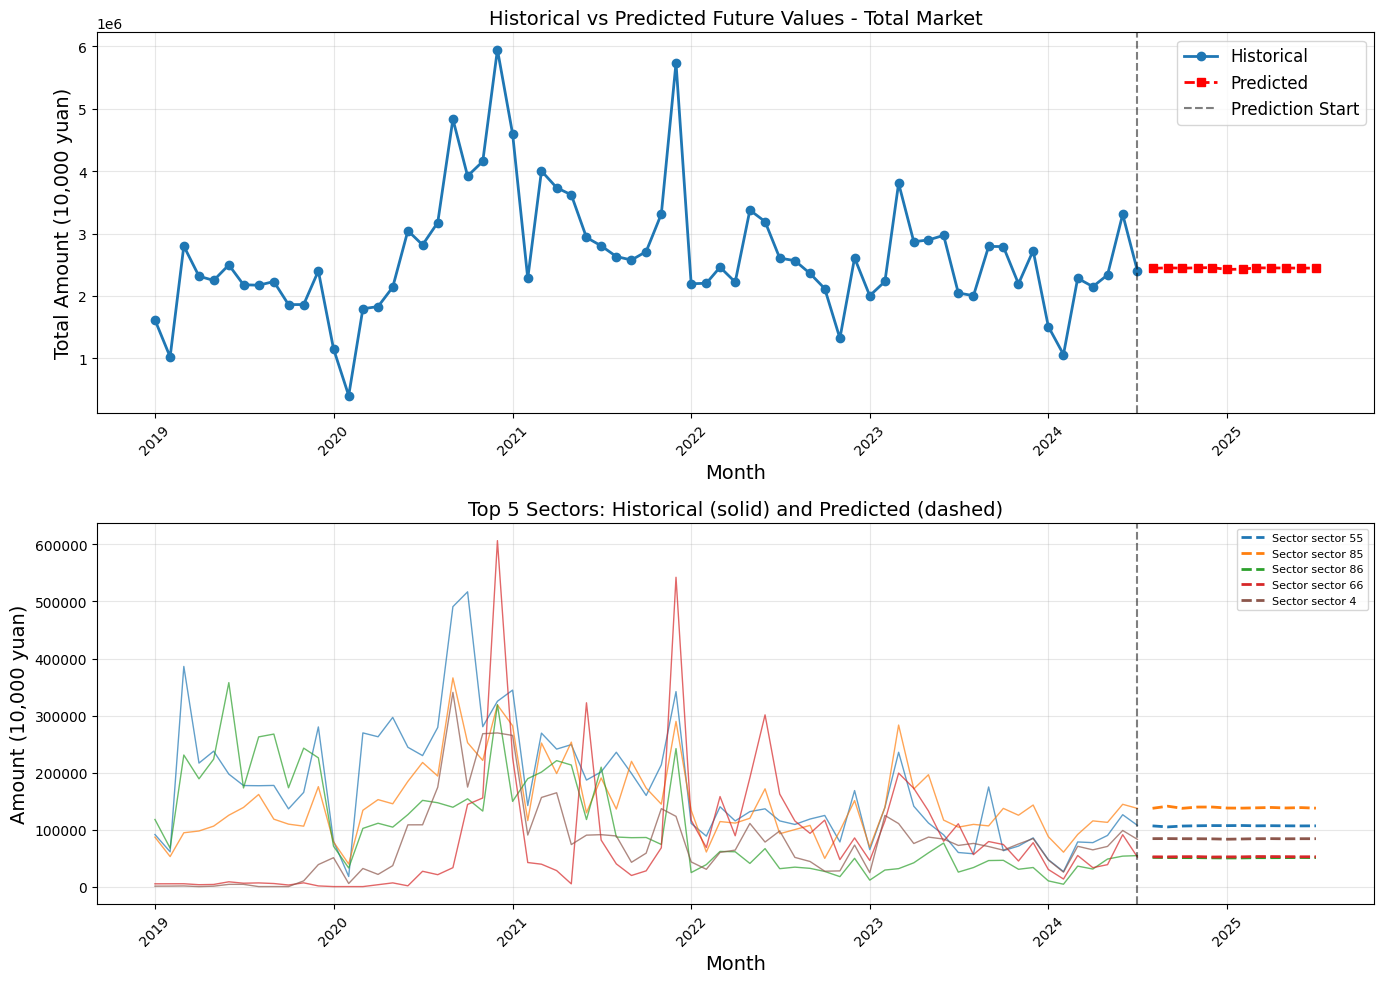


PREDICTION SUMMARY

Historical last 3 months avg: 2,684,372
Predicted next 3 months avg: 2,446,562
Expected growth rate: -8.9%

Top sectors predicted growth:
  Sector sector 55: +27.1%
  Sector sector 85: +21.1%
  Sector sector 86: +42.1%


In [23]:
# ==========================================
# 7.2 VISUALIZE PREDICTIONS (UPDATED)
# ==========================================

import matplotlib.pyplot as plt

print("="*60)
print("VISUALIZING PREDICTIONS")
print("="*60)

# Historical data
last_historical_month = df['month'].max()
historical_data = combined_df[combined_df['month'] <= last_historical_month].copy()

# Future predictions
future_data = combined_df[combined_df[target_col].isna()].copy()
future_data['predicted_amount'] = predictions_clipped

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ------------------------------------------
# Plot 1: Total monthly amounts
# ------------------------------------------

historical_monthly = historical_data.groupby('month')[target_col].sum()
future_monthly = future_data.groupby('month')['predicted_amount'].sum()

axes[0].plot(historical_monthly.index, historical_monthly.values, 
             label='Historical', marker='o', linewidth=2, color='#1f77b4')
axes[0].plot(future_monthly.index, future_monthly.values, 
             label='Predicted', marker='s', linewidth=2, linestyle='--', color='red')
axes[0].axvline(last_historical_month, color='black', linestyle='--', alpha=0.5, label='Prediction Start')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Amount (10,000 yuan)')
axes[0].set_title('Historical vs Predicted Future Values - Total Market')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# ------------------------------------------
# Plot 2: Top 5 sectors
# ------------------------------------------

# Map sector codes to labels (optional, if you have a mapping dictionary)
sector_mapping = {i: f'Sector {i}' for i in df['sector'].unique()}

# Top 5 sectors by historical volume
top_sectors = historical_data.groupby('sector')[target_col].sum().nlargest(5).index

colors = plt.cm.tab10(np.linspace(0, 0.5, 5))

for i, sector in enumerate(top_sectors):
    sector_hist = historical_data[historical_data['sector'] == sector].groupby('month')[target_col].sum()
    sector_future = future_data[future_data['sector'] == sector].groupby('month')['predicted_amount'].sum()
    
    axes[1].plot(sector_hist.index, sector_hist.values, alpha=0.7, linewidth=1, color=colors[i])
    axes[1].plot(sector_future.index, sector_future.values, linestyle='--', linewidth=2, color=colors[i],
                 label=sector_mapping.get(sector, str(sector)))

axes[1].axvline(last_historical_month, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Amount (10,000 yuan)')
axes[1].set_title('Top 5 Sectors: Historical (solid) and Predicted (dashed)')
axes[1].legend(fontsize=8, loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ------------------------------------------
# Summary Statistics
# ------------------------------------------

print("\n" + "="*40)
print("PREDICTION SUMMARY")
print("="*40)

hist_last_3_months = historical_monthly.tail(3).mean()
pred_first_3_months = future_monthly.head(3).mean()
growth_rate = (pred_first_3_months - hist_last_3_months) / hist_last_3_months * 100

print(f"\nHistorical last 3 months avg: {hist_last_3_months:,.0f}")
print(f"Predicted next 3 months avg: {pred_first_3_months:,.0f}")
print(f"Expected growth rate: {growth_rate:+.1f}%")

print("\nTop sectors predicted growth:")
for sector in top_sectors[:3]:
    hist_avg = historical_data[historical_data['sector'] == sector][target_col].tail(12).mean()
    pred_avg = future_data[future_data['sector'] == sector]['predicted_amount'].mean()
    growth = (pred_avg - hist_avg) / hist_avg * 100 if hist_avg > 0 else 0
    print(f"  {sector_mapping.get(sector, str(sector))}: {growth:+.1f}%")